In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from mne_features.feature_extraction import extract_features,FeatureExtractor
from mne_features.univariate import compute_pow_freq_bands
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
mne.set_log_level('WARNING')
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.cm as cm
from sklearn.feature_selection import RFECV

E:\Anaconda3\envs\mne\lib\site-packages\mne_features\mock_numba.py:12: UserWarning: No module named 'numba'. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [2]:
metric="roc_auc"
root_path=r'E:\ZKP\persons comparision\Band Analysis\Epoch\Epoch_Super'
drug_path_before=os.path.join(root_path,'drug_before')
health_path=os.path.join(root_path,'health')
drug_path_after=os.path.join(root_path,'drug_after')
drug_path_before_s2=os.path.join(root_path,'drug_before_s2')
health_path_s2=os.path.join(root_path,'health_s2')
drug_path_after_s2=os.path.join(root_path,'drug_after_s2')
bands=["gamma"]
L_frontal_lobe=['Fp1','F3','F7','FC5','FC1','FT9']
L_parietal_lobe=['CP5','CP1','P3','P7']
Parieto_occipital_region=['Pz','O1','O2']
Central_region=['C3', 'C4', 'Cz']
Temporal_region=['T7','T8','TP9','TP10']
R_parietal_lobe=['CP6','CP2','P4','P8']
R_frontal_lobe=['Fp2','F4','F8','FC6','FC2','FT10']
frontal_lobe=L_frontal_lobe+R_frontal_lobe+['L_frontal_lobe','R_frontal_lobe']
fc_lobe=frontal_lobe+Central_region+['Central_region']
parietal_lobe=L_parietal_lobe+R_parietal_lobe+['L_parietal_lobe','R_parietal_lobe']
o_lobe=parietal_lobe+Parieto_occipital_region+['Parieto_occipital_region']+Temporal_region+['Temporal_region']

C:\Users\ZENG\AppData\Local\Temp\ipykernel_33748\928844700.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_=cm.get_cmap("tab20b")


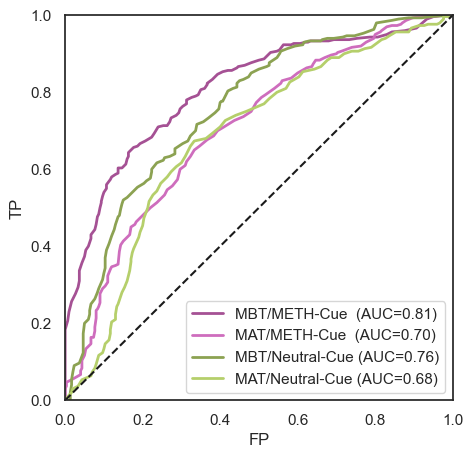

In [7]:

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, cross_val_predict



cmap_choosen=[17,18,5,6]
def train_RF_list(X_list, y_list):
    sns.set(style='white')
    plt.figure(figsize=(5, 5))
    labels=['MBT/METH-Cue','MAT/METH-Cue','MBT/Neutral-Cue','MAT/Neutral-Cue']
    cmap_=cm.get_cmap("tab20b")
    for i in range(len(X_list)):
        X_ = X_list[i]
        y_ = y_list[i]
        clf_ = make_pipeline(StandardScaler(), RandomForestClassifier())
        y_scores = cross_val_predict(clf_, X_, y_, cv=StratifiedKFold(n_splits=5), method='predict_proba')[:, 1]
        fpr, tpr, thresholds = roc_curve(y_, y_scores)
        auc = roc_auc_score(y_, y_scores)
        if i<2:
            label = '{}  (AUC={:.2f})'.format(labels[i], auc)
        else:
            label = '{} (AUC={:.2f})'.format(labels[i], auc)
        plt.plot(fpr, tpr, label=label,color=cmap_(cmap_choosen[i]),linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
    plt.xlabel('FP')
    plt.ylabel('TP')
    plt.legend(loc='lower right')
    # sns.despine()
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()

def loadAndCombine(file_path):
    dfs=[]
    for specific_band in bands:
        df=pd.read_excel(os.path.join(file_path,specific_band+'.xlsx'))
        dfs.append(df)
    dfs=np.mean(dfs,axis=0)
    return dfs    
def getOnePair(path_b,path_a,path_h):
    X_list,y_list=[],[]
    drug_data_before=loadAndCombine(path_b)
    drug_data_after=loadAndCombine(path_a)
    health_data=loadAndCombine(path_h)
    X=np.concatenate((drug_data_before,health_data),axis=0)
    y=np.concatenate((np.ones(drug_data_before.shape[0]),np.zeros(health_data.shape[0])),axis=0)
    X_list.append(X)
    y_list.append(y)
    X=np.concatenate((drug_data_after,health_data),axis=0)
    y=np.concatenate((np.ones(drug_data_after.shape[0]),np.zeros(health_data.shape[0])),axis=0)
    X_list.append(X)
    y_list.append(y)
    return X_list,y_list
def run_algo(pair):
    X_lists,y_lists=[],[]
    path_b,path_a,path_h=pair[:3]
    X_list,y_list=getOnePair(path_b,path_a,path_h)
    X_lists.extend(X_list)
    y_lists.extend(y_list)
    
    path_b,path_a,path_h=pair[3:6]
    X_list,y_list=getOnePair(path_b,path_a,path_h)
    X_lists.extend(X_list)
    y_lists.extend(y_list)

    train_RF_list(X_lists,y_lists)

run_algo([drug_path_before,drug_path_after,health_path,drug_path_before_s2,drug_path_after_s2,health_path_s2])